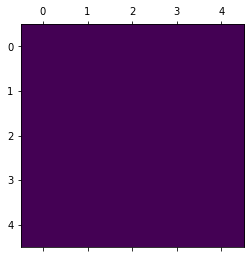

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import threading
import array
from threading import Thread, Condition
import time
import random

n = random.randint(2,9)
'''postavljamo vrednosti matrice'''


vals = [1, 0]
broj_waitovanih = 0


x1 = 0
y1 = 0


'''pravimo matricu brojac suseda koja je ce nam govoriti koliko je suseda procitalo nasu vrednost'''
brojac_suseda = np.zeros((n,n))
''' brojac_suseda = [[ 0.  0.  0.  0.]
                    [ 0.  0.  0.  0.]
                    [ 0.  0.  0.  0.]
                    [ 0.  0.  0.  0.]]'''


''' matrica total ce za vrednosti [x][y] pokazivati koliko imamo ON vrednosti nasih suseda'''
total = np.zeros((n,n))
'''         total = [[ 0.  0.  0.  0.]
                    [ 0.  0.  0.  0.]
                    [ 0.  0.  0.  0.]
                    [ 0.  0.  0.  0.]]'''



izracunat_total = np.zeros((n,n))

def randomGrid(N):
 
    """returns a grid of NxN random values"""
    return np.random.choice(vals, N*N, p=[0.7, 0.3]).reshape(N, N)



''' pravimo semafor za svako polje matrice'''
budjenje_za_upis =[threading.Semaphore(0) for i in range(n*n)]
condition = threading.Condition()
mutex = threading.Semaphore(1)
upisivanje_kljuc = threading.Lock()
kluc_slanje = threading.Lock()


matrica = np.array([])
matrica =  randomGrid(n)

n=5
matrica = np.array([[0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1],
                  [0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1],
                  [0, 0, 0, 0, 0]])

''' na pocetku ubacujemo random matricu u steps i postavljamo upisane vrednosti na nula, jer niko jos uvek nije promenio stanje'''
upisane_nove_vrednosti = 0
steps = [matrica]

''' kopiramo nasu matricu i punimo steps, a ostale vrednosti cemo kasnije pregaziti novim matricama'''
for i in range(10):
  steps.append(np.zeros((n,n)))



def broj_pomocu_kordinati(x,y):
  return (n * x + y)


''' funckija koja ce na pocetku za sve celije da nam acq semafor i da ceka release za celiju koja je ispunila uslov,a zatim da postavi njenu novu vrednost'''


def upisivanjeVrednosti(x,y,brojac_celije):
  global upisane_nove_vrednosti
  global broj_waitovanih
 

  for broj_iteracije1 in range(10):
   
   budjenje_za_upis[brojac_celije].acquire()
   mutex.acquire()
   
#    print(f'Za {x} i {y} iz Upis, total = {total[x][y]}')
  
   ''' povecavanjem broja iteracije se krecemo kroz steps i pristupamo zeljenoj matrici'''
   if(steps[broj_iteracije1][x][y] == 1):

      if((total[x][y] < 2) or (total[x][y] > 3)):
          steps[broj_iteracije1 + 1][x][y] = 0
      else:
          steps[broj_iteracije1 + 1][x][y] = 1
      
   else:
      if(total[x][y] == 3):
          steps[broj_iteracije1 + 1][x][y] = 1
      
      else:
          steps[broj_iteracije1 + 1][x][y] = 0      


   total[x][y] = 0
   izracunat_total[x][y] = 0  

   mutex.release()

   upisivanje_kljuc.acquire()

   upisane_nove_vrednosti +=1
  

   

   

   ''' kada upisemo vrednost, sve dok ona nije promenjena za sve celije, ne radimo nista.
   Kada svi upisu novu vrednost pozivano notifyAll() koji ce u funkciji celija da probudi niti koje su na wait() i 
   krenuce nova iteracija'''

  

   if(upisane_nove_vrednosti == (n*n)):
      
     
      upisane_nove_vrednosti = 0
      ''' kada svi upisu novu vrednost resetujemo borjac za upisane vrednosti'''
      while(broj_waitovanih < n*n ):
        continue
  
      
      condition.acquire()
      condition.notifyAll()
      broj_waitovanih = 0
      condition.release()
   upisivanje_kljuc.release()
   time.sleep(0.1)
      





def celija(x,y,brojac_celije):

 global x1,y1
 global vals
 global brojac_suseda
 global matrica
 global steps
 global matrica1 
 global broj_waitovanih
 for broj_iteracije in range(10):
  
  mutex.acquire()
 
  for i1 in range(x-1, x+2):
            for j1 in range(y-1, y+2):
                if(i1==x and j1==y):
                    continue;
                if(steps[broj_iteracije][i1%n, j1%n] == 1):
                   total[x][y] += 1

  ''' racunamo nase stanje u odnosu na susede
  total[x][y] =int((steps[broj_iteracije][x, (y-1)%n] + steps[broj_iteracije][x, (y+1)%n] +
              steps[broj_iteracije][(x-1)%n, y] + steps[broj_iteracije][(x+1)%n, y] +
              steps[broj_iteracije][(x-1)%n, (y-1)%n] + steps[broj_iteracije][(x-1)%n, (y+1)%n] +
              steps[broj_iteracije][(x+1)%n, (y-1)%n] + steps[broj_iteracije][(x+1)%n, (y+1)%n]) / 255)'''
  
 
  izracunat_total[x][y] = 1


#   print(f'Za {x} i {y} iz Celija, total = {total[x][y]}')
  
  ''' povecavamo brojac suseda za one vrednosti kojima smo pristupili iznad jer su svih 8 obavestili trenutnu [x][y] nit o svojim vrednostima'''
  brojac_suseda[x][(y-1)%n] += 1
  brojac_suseda[x][(y+1)%n] += 1
  brojac_suseda[(x-1)%n][y] += 1
  brojac_suseda[(x+1)%n][y] += 1
  brojac_suseda[(x-1)%n][(y-1)%n] += 1
  brojac_suseda[(x-1)%n][(y+1)%n] += 1
  brojac_suseda[(x+1)%n][(y-1)%n] += 1
  brojac_suseda[(x+1)%n][(y+1)%n] += 1

 

  mutex.release()

  
      
  if(8 in brojac_suseda):
    kluc_slanje.acquire()
    
    ''' kada se pojavi polje koje je obavestilo sve susede o svojoj vrednosti, ulazimo u ovaj if'''
    a = np.where(brojac_suseda==8)
    
    ''' pravimo niz koji sadrzi koordinate polja koja su usla ovde'''

    for br in range(np.size(a[0])):
        x1 = a[0][br]
        y1 = a[1][br]
        ''' izvlacimo koordinate u x1 i y1'''

        brojac_suseda[x1][y1] = 0
        ''' na to polje postavljamo 0, jer ne zelimo opet da ga racunamo'''
        
        while(izracunat_total[x1][y1] == 0):
          continue


        budjenje_za_upis[broj_pomocu_kordinati(x1,y1)].release()
       
        ''' pozivamo prvo funkciju broj_pomocu_kordinati koji nam vraca broj semafora nase celije'.
        Zatim za tu odredjenu celiju releasujemo semafor i ona moze da menja vrednost'''

    kluc_slanje.release()     
  condition.acquire() 
  
  ''' na kraju, sve niti cekaju da se upisu sve nove vrednosti i onda sa notifyAll() budimo sve i krecemo novu iteraciju'''
  broj_waitovanih += 1
  condition.wait()
    

  condition.release()
  time.sleep(0.1)
  
  
  
  




def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  
  

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim

threads = []
threads1 = []

for i in range(n):
        for j in range(n):
            thread = threading.Thread(target=upisivanjeVrednosti,args=(i,j,n*i + j))
            threads.append(thread)

for i in range(n):
        for j in range(n):
            thread = threading.Thread(target=celija,args=(i,j,n*i + j))
            threads1.append(thread)

for thread in threads:
        thread.start()

for thread in threads1:
        thread.start()       

for thread in threads:
        thread.join()


for thread in threads1:
        thread.join() 




anim = animate(steps);
HTML(anim.to_html5_video())